## Introduction

This notebook accompanies the paper "Impact of non-parabolic electronic band structure on the optical, defect, and transport properties of photovoltaic materials". It reproduces some of the key results from the paper and includes supplementary information. It makes extensive use of the [effmass](http://github.com/lucydot/effmass) package which is available to download on github.

The effmass package contains the [data files](https://github.com/lucydot/effmass/tree/master/paper/data) needed to reproduce all results in the paper. Here we focus upon a subset of that data to calculate:
- Effective mass and non-parabolicity of CdTe 
- Burstein Moss shift and optical effective mass in MAPI

In both cases we use data calculated using the HSE06 functional with spin-orbit coupling. However, the notebook can be easily adapted to explore other materials and levels of theory if required.

## Imports and preamble

In [4]:
# plots displayed within notebook
%matplotlib inline

# import scientific libraries
import math
import matplotlib.pyplot as plt
import numpy as np

# import modules from the effmass package
from effmass import inputs, analysis, extrema, outputs, dos, ev_to_hartree

## Effective mass and non-parabolicity of CdTe

### Settings
First we use the `inputs` module to create a `Settings` object. The `extrema_search_depth` attribute tells us how far from the CBM/VBM we would like to search for the bandstructure minima/maxima. The `energy_range` attribute sets the energy range for each band `Segment`. 

In [5]:
settings = inputs.Settings(extrema_search_depth=0.075, energy_range=0.25)

### Import bandstructure data
We now use the `inputs` module to create a `Data` object which automatically imports the vasp data from the files specified. We manually specify how many k-points to ignore at the start of each file. These are the k-points which are included as part of the non-self-consistent bandstructure calculation, but which do not form part of the bandstructure itself.

In [7]:
data = inputs.Data("./paper/data/CdTe/HSE06_SoC/OUTCAR","./paper/data/CdTe/HSE06_SoC/PROCAR", ignore=216)

To import FHI-Aims data we use a similar command, this time specifying the path to the directory containing output, geometry.in, control.in and bandstructure files. The rest of the workflow is independant of the DFT calculator used, although DOS-related functionality is not currently supported for FHI-Aims.

In [16]:
Aims_data = inputs.DataAims("./tests/data_aims/Ge_sp_aims/")

### Generate band segments
We can now use our `Settings` and `Data` objects to generate a list of `Segment` objects using the `extrema` module. 

In [17]:
segments = extrema.generate_segments(settings,data)

Each Segment has a string method which gives the energy of the Segment extrema (referenced to the VBM) and the start- and end- points of the Segment in reciprocal space.

In [18]:
str(segments[-1])

'0.03 eV; [0.5 0.5 0.5]-->[0.49  0.49  0.519]'

### Visualise band segments
We can visualise the `Segment` objects created using the `outputs` module. The plot is annotated with the `Segment`'s direction and segments argument index.

In [20]:
outputs.plot_segments(data,settings,segments)

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10aaa6978>)

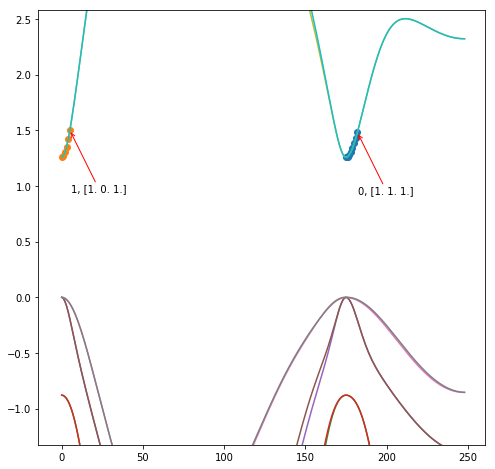

In [49]:
outputs.plot_segments(data,settings,[segments[-1],segments[-3]])

### Calculate parabolic effective mass
There are a number of methods associated with each `Segment` object. We can use these to calculate the different definitions of effective mass, assuming a parabolic dispersion $E= \frac{\hbar^2k^2}{2m^*}$. 

In [7]:
segments[-1].five_point_leastsq_effmass()

0.09061386126453852

In [8]:
segments[-1].finite_difference_effmass()

0.092155278777688338

In [9]:
segments[-1].weighted_leastsq_effmass()

0.095174661409246172

We can use inbuilt documentation to find out more about a particular method.

In [10]:
analysis.Segment.weighted_leastsq_effmass?

### Calculate parameters for the Kane dispersion 
The alpha parameter quantifies the extent of non-parabolicity in the kane dispersion $\frac{\hbar^2k^2}{2m^*_0} = E(1 + \alpha E) $
where $m^*_0$ is the mass at the band edge ($E=0$).

In [11]:
segments[-1].alpha() # note that atomic units are used (hartree^-1)

27.782410846735118

In [12]:
segments[-1].kane_mass_band_edge() 

0.089285653580707308

### Summarise results

The `print_results` function in the `outputs` module summarises the results for a segment. 

electron [ 1.  1.  1.]
3-point finite difference mass is 0.09
3-point parabolic mass is 0.09
weighted parabolic mass is 0.10
alpha is 1.02 1/eV
kane mass at bandedge is 0.09
the Kane quasi-linear approximation is valid until 0.22 eV
optical mass at band edge (assuming the Kane dispersion) is 0.10


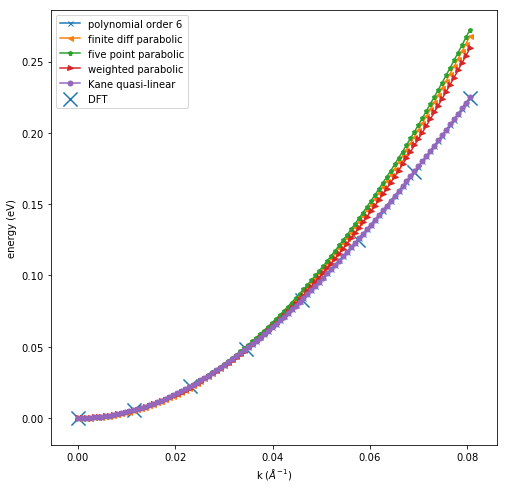

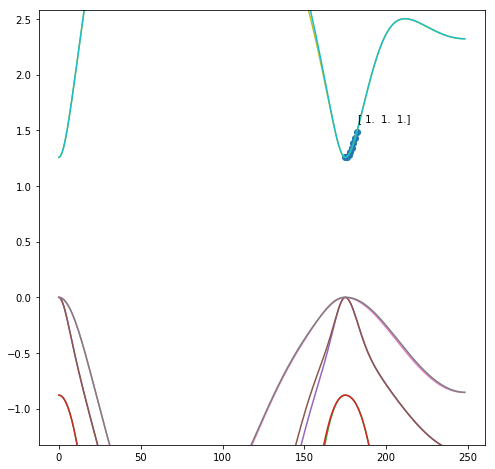

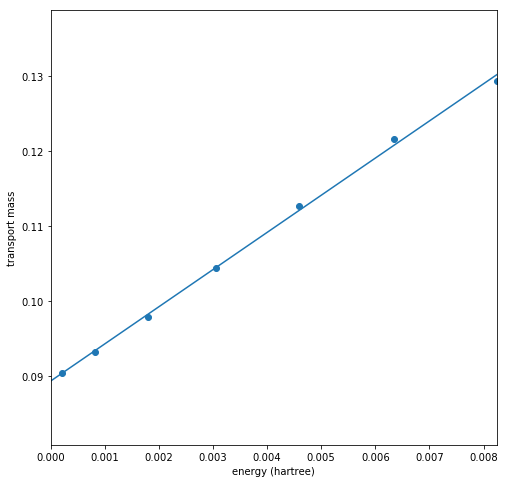

In [13]:
outputs.print_results(segments[-1], data, settings)

## Burstein Moss shift and optical effective mass in MAPI

### Settings, Data and Segments
As in the previous example we create a `Settings` object and `Data` object then use these to create a list of `Segment` objects.

In [14]:
settings = inputs.Settings(extrema_search_depth=0.075, energy_range=0.75)
data = inputs.Data("./paper/data/MAPI/HSE06_SoC/OUTCAR","./paper/data/MAPI/HSE06_SoC/PROCAR",ignore=216)
segments = extrema.generate_segments(settings,data)

### Kane dispersion parameters
To calculate the non-parabolic burstein-moss shift we need to know the electron alpha parameter and bandedge transport effective mass. First, let's see the segments we have generated

(<matplotlib.figure.Figure at 0x10f07f9e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f07f940>)

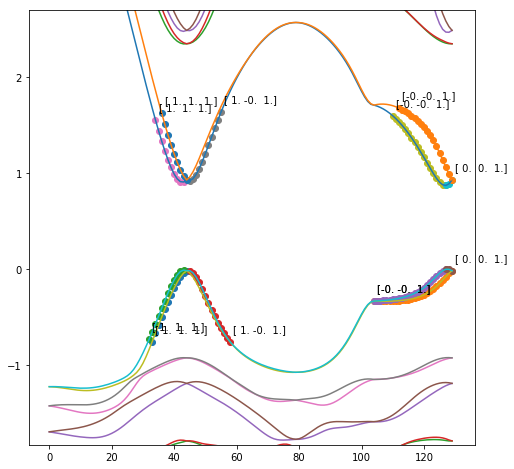

In [15]:
outputs.plot_segments(data,settings,segments)

We want to calculate the kane dispersion parameters for `segments[-4]`, `segments[-5]` and `segments[-6]`. These parameters depend upon the `Settings.energy_range` attribute and the order of the polyfit used for calculating the transport mass. We can adjust the `energy_range` and polyfit order until we get a good fit to data. 

electron [-0. -0.  1.]
3-point finite difference mass is 0.15
3-point parabolic mass is 0.18
weighted parabolic mass is 0.19
alpha is 2.21 1/eV
kane mass at bandedge is 0.16
the Kane quasi-linear approximation is valid until 0.23 eV
optical mass at band edge (assuming the Kane dispersion) is 0.18


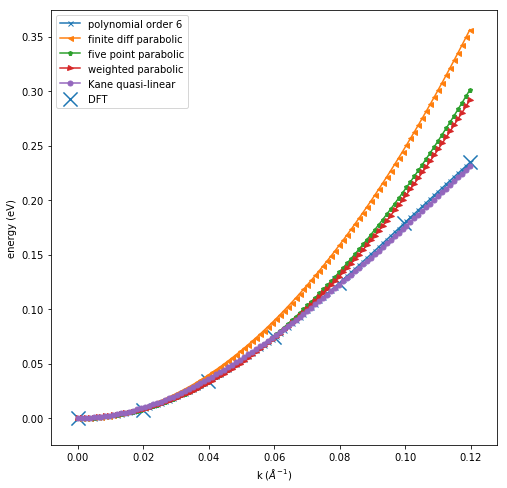

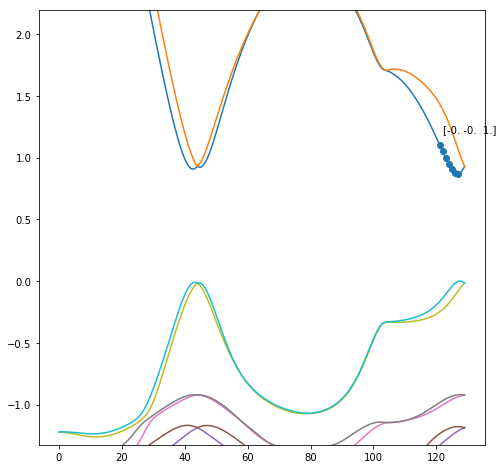

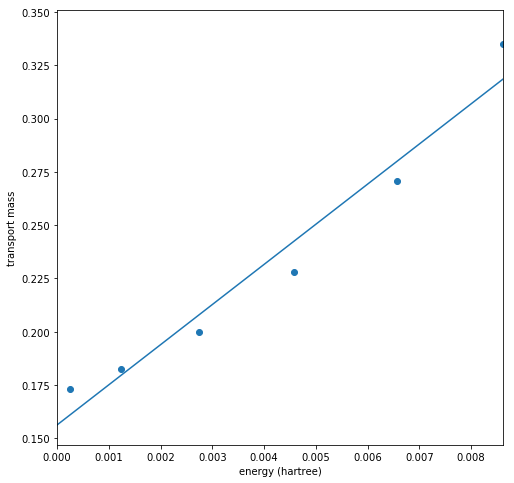

In [16]:
# energy_range=0.25, polyfit_order=6 for optimal fitting in 001 direction

settings = inputs.Settings(extrema_search_depth=0.075, energy_range=0.25)
segments = extrema.generate_segments(settings, data)
outputs.print_results(segments[-4],data,settings,polyfit_order=6)

electron [ 1. -0.  1.]
3-point finite difference mass is 0.13
3-point parabolic mass is 0.10
weighted parabolic mass is 0.10
alpha is 1.50 1/eV
kane mass at bandedge is 0.10
the Kane quasi-linear approximation is valid until 0.46 eV
optical mass at band edge (assuming the Kane dispersion) is 0.11


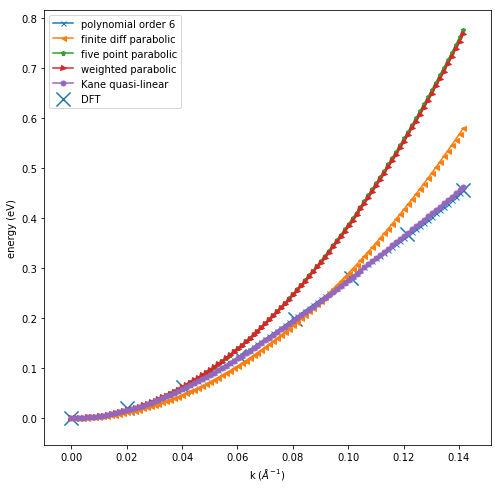

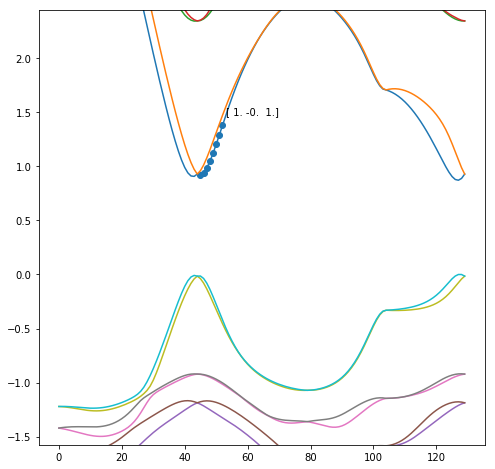

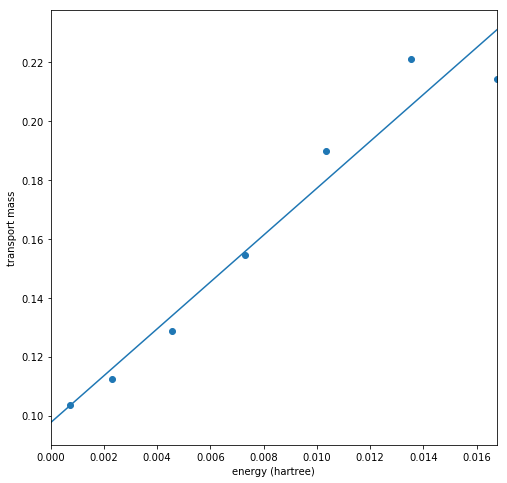

In [17]:
# energy_range=0.5, polyfit_order=6 for optimal fitting in 101 direction

settings = inputs.Settings(extrema_search_depth=0.075, energy_range=0.5)
segments = extrema.generate_segments(settings, data)
outputs.print_results(segments[-5],data,settings,polyfit_order=6)

electron [ 1.  1.  1.]
3-point finite difference mass is 0.12
3-point parabolic mass is 0.19
weighted parabolic mass is 0.18
alpha is 0.16 1/eV
kane mass at bandedge is 0.16
the Kane quasi-linear approximation is valid until 0.33 eV
optical mass at band edge (assuming the Kane dispersion) is 0.16


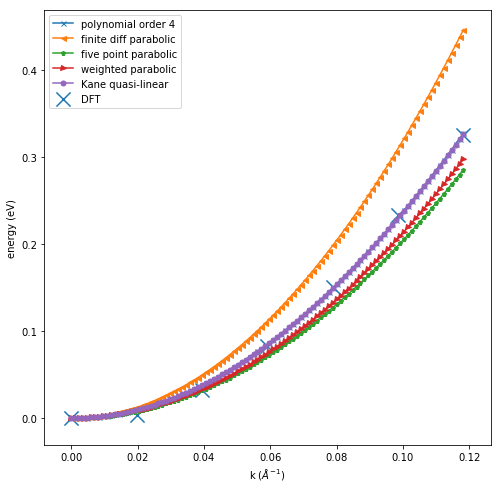

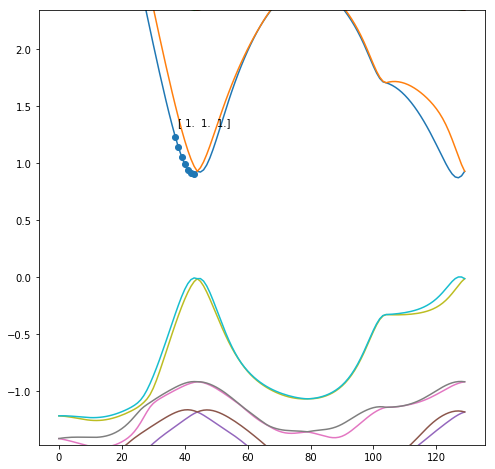

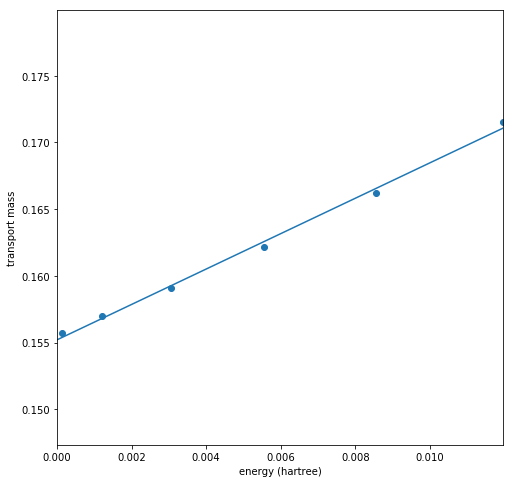

In [18]:
# energy_range=0.4, polyfit_order=4 for optimal fitting in 111 direction

settings = inputs.Settings(extrema_search_depth=0.075, energy_range=0.4)
segments = extrema.generate_segments(settings, data)
outputs.print_results(segments[-6],data,settings,polyfit_order=4)

### Burstein Moss shift

The Burstein Moss shift is calculated using analytic expression $\Delta_{BM} =\frac{\hbar^2}{2m^*}(3\pi^2n_e)^{2/3}$ where the effective mass $m^*$ is constant (in the case of a parabolic dispersion) or takes the form $m^*(E) = m_0^*(1+2 \alpha E)$ (for a Kane dispersion).

In [23]:
def burstein_moss_parabolic(mass,concentration):
    # the expression comes from the fermi energy for a given concentration, assuming parabolic dispersion
    # the fermi wavevector is simply gotten from considering volume of sphere in reciprocal space / volume of each eigenstate (factor 2 for spin)
    concentration = concentration * ((5.29E-9)**3) # convert cm-3 --> bohr-3
    return (((3*math.pi*math.pi*concentration)**(2/3))/(2*mass))/ev_to_hartree

def burstein_moss_kane(concentration,mass,alpha):
    # this expression is an adaptation of the one above where the mass is now dependant upon the shift m_t = m_o(1+2 \alpha E) 
    concentration = concentration * ((5.29E-9)**3) # convert cm-3 --> bohr-3
    return (analysis._solve_quadratic(2*alpha,1,[-((3*math.pi*math.pi*concentration)**(2/3)/(2*mass))])[0])/ev_to_hartree

We take a mean average of the alpha value across the three directions

In [24]:
average_alpha = (2.214+1.499+0.16)/(3*(ev_to_hartree)) # convert back to atomic units

The geometric average of the mass is calculated for electrons and holes. Unlike silicon which has 6 equivalent minima and a degeneracy of 6, the minima here are between $\Gamma-R$ which has a multiplicity of 1. These average values are then combined into a reduced mass.

In [25]:
def dos_average(m1,m2,m3,degeneracy=1):
    # density of states mass which is used instead of conductivity effective mass as electron concentration populates entire 3D brillouin zone
    # this perhaps needs a weighting factor to account for not mx,my,mz
    return ((m1*m2*m3)**(1/3))*(degeneracy**(2/3))

def reduced_mass(m_e,m_h):
    return 1/((1/m_e)+(1/m_h))

# effective mass at bandedge calculated from bandstructure
em1 = 0.19
em2 = 0.10
em3 = 0.18
hm1 = 0.23
hm2 = 0.10
hm3 = 0.12

average_mass=reduced_mass(dos_average(em1,em2,em3),dos_average(hm1,hm2,hm3))


Calculate the Burstein Moss shifts for concentration range $1 \times 10^{16}$ to $ 3 \times 10^{20}$

In [26]:
concentrations = np.logspace(16,np.log10(3E20),100)
parabolic_bandshift = [burstein_moss_parabolic(average_mass,x) for x in concentrations]
kane_bandshift = [burstein_moss_kane(x,average_mass,average_alpha) for x in concentrations]

### Import density of states data
We can compare these values to density of states data. We start by parsing the DOSCAR file.

In [27]:
data.parse_DOSCAR("./paper/data/MAPI/HSE06_SoC/DOSCAR")

We can use this data and the `dos` module to calculate the band filling level for a given concentration. We also need to supply the volume of the unit cell in $\unicode{x212B} ^3$.

In [28]:
volume = 251.13
dos_bandshift = [dos.electron_fill_level(data, volume, x, dos.find_dos_CBM_index(data))for x in concentrations]

### Compare results

Let's plot the three bandshift results:

(0, 2.5)

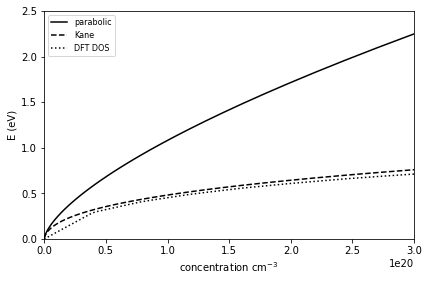

In [29]:
fig = plt.figure()
plt.plot(concentrations,parabolic_bandshift, "-",label="parabolic",color="black")
plt.plot(concentrations,kane_bandshift,"--",label="Kane",color="black")
plt.plot(concentrations,dos_bandshift, ":",label="DFT DOS",color="black")
plt.legend(prop={'size': 8},loc=2)
plt.xlabel(r"concentration cm$^{-3}$")
plt.ylabel("E (eV)")
plt.tight_layout()
plt.savefig("burstein_moss_MAPI_hybrid_SoC.pdf")
plt.xlim([0,3E20])
plt.ylim([0,2.5])

### Calculate optical effective mass as a function of concentration
Our results show that the Kane dispersion is a good approximation to the density of states data (which makes no assumptions about the band dispersions). We can calculate an optical effective mass:
$\begin{equation}
\frac{1}{m_o} = \frac{\sum_{l} \int f(E_k(k),T) \frac{\delta^2 E_k(k)}{\delta k^2} dk}{\sum_{l} \int f(E_k(k),T) dk}
\end{equation}$

with $E(K)$ set to the Kane dispersion. The Fermi level in the Fermi-Dirac distribution $f(E_k(k),T)$ is set to the burstein-moss shift as calculated using the Kane dispersion.

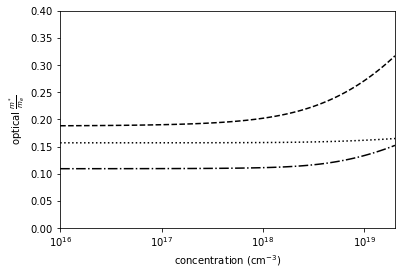

In [31]:
settings = inputs.Settings(extrema_search_depth=0.075, energy_range=0.25)  # kane dispersion valid up to energy_range 0.25eV
segments = extrema.generate_segments(settings, data)
concentrations = np.logspace(16,np.log10(2E19),100) # if we set the concentration higher we exceed energies where the kane dispersion is valid and receive a warning

optical_mass_111 = [segments[-6].optical_effmass_kane_dispersion(fermi_level=data.CBM+burstein_moss_kane(x,average_mass,average_alpha),alpha=0.16/ev_to_hartree,mass_bandedge=0.155,upper_limit=0.1) for x in concentrations]
optical_mass_110 = [segments[-5].optical_effmass_kane_dispersion(fermi_level=data.CBM+burstein_moss_kane(x,average_mass,average_alpha),alpha=1.499/ev_to_hartree,mass_bandedge=0.098,upper_limit=0.1) for x in concentrations]
optical_mass_100 = [segments[-4].optical_effmass_kane_dispersion(fermi_level=data.CBM+burstein_moss_kane(x,average_mass,average_alpha),alpha=2.214/ev_to_hartree,mass_bandedge=0.156,upper_limit=0.1) for x in concentrations]

## Plot results

fig,ax1 = plt.subplots()

ax1.plot(np.log10(concentrations),optical_mass_111,":",label="(111) ",color="black")
ax1.plot(np.log10(concentrations),optical_mass_110,"-.",label="(110) ",color="black")
ax1.plot(np.log10(concentrations),optical_mass_100,"--",label="(100) ",color="black")

ax1.set_xticks([16,17,18,19])
ax1.set_xticklabels([r"$10^{16}$",r"$10^{17}$",r"$10^{18}$",r"$10^{19}$"])
ax1.set_xlim([16,np.log10(2E19)])
ax1.set_ylim([0,0.4])

ax1.set_xlabel(r"concentration (cm$^{-3}$)")
ax1.set_ylabel(r"optical $\frac{m^*}{m_e}$")